In [511]:
cd ~/data/modl_data/pipeline/contrast/prediction/698/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/698


In [512]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [513]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [514]:
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

pipeline = Pipeline(estimator.steps[:-1])

In [515]:
model = estimator.steps[-1][1].best_estimator_.model_

layer0 =  model.layers_by_depth[0][0]
layer1 =  model.layers_by_depth[1][0]

w0, b0 = layer0.get_weights()
w1 = layer1.get_weights()[0]

coef = w1.dot(w0).T
intercept = b0

In [516]:
model

In [517]:
model = estimator.steps[-1][1]
coef = model.coef_
intercept = model.intercept_

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [518]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [519]:
pipeline.named_steps['feature_importance'].feature_importance[:] = 1
maps = pipeline.inverse_transform(coef)

mask = fetch_hcp(n_subjects=1).mask
masker = MultiNiftiMasker(mask_img=mask).fit()
imgs = masker.inverse_transform(maps)

print('Shape', imgs.shape)

Shape (91, 109, 91, 30)


In [520]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [521]:
datasets

array(['archi'], dtype=object)

In [522]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [523]:
from sklearn.metrics import confusion_matrix

In [524]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

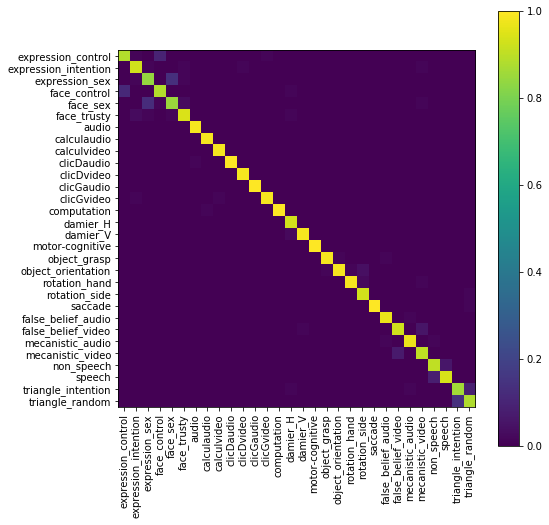

In [532]:
plot_confusion_matrix(train_conf, labels)

In [526]:
est = estimator.steps[-1][1]

In [527]:
est.best_params_

{'alpha': 0.001, 'latent_dim': 100}

In [528]:
est.cv_results_

{'mean_fit_time': array([ 5.68209143,  5.6573509 ,  6.01388876,  6.17050328]),
 'mean_score_time': array([ 0.02668564,  0.02284338,  0.02531497,  0.0256145 ]),
 'mean_test_score': array([ 0.77      ,  0.77047619,  0.80619048,  0.82761905]),
 'mean_train_score': array([ 0.96433862,  0.9673545 ,  0.97222222,  0.9552381 ]),
 'param_alpha': masked_array(data = [9.9999999999999995e-07 1.0000000000000001e-05 0.0001 0.001],
              mask = [False False False False],
        fill_value = ?),
 'param_latent_dim': masked_array(data = [100 100 100 100],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'alpha': 9.9999999999999995e-07, 'latent_dim': 100},
  {'alpha': 1.0000000000000001e-05, 'latent_dim': 100},
  {'alpha': 0.0001, 'latent_dim': 100},
  {'alpha': 0.001, 'latent_dim': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([ 0.70952381,  0.71428571,  0.75238095,  0.75714286]),
 'split0_train_score': array([ 0.9

In [529]:
plt.show()

In [530]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task       contrast            
archi    emotional  expression_control      0.250
                    expression_intention    0.875
                    expression_sex          0.625
                    face_control            1.000
                    face_sex                0.500
                    face_trusty             0.750
         localizer  audio                   0.875
                    calculaudio             1.000
                    calculvideo             0.750
                    clicDaudio              0.875
                    clicDvideo              0.875
                    clicGaudio              1.000
                    clicGvideo              0.875
                    computation             1.000
                    damier_H                1.000
                    damier_V                1.000
                    motor-cognitive         1.000
         parietal   object_grasp            1.000
                    object_orientation      0.625
         

In [531]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.850000
train  archi      0.947619
Name: match, dtype: float64

In [394]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

KeyboardInterrupt: 

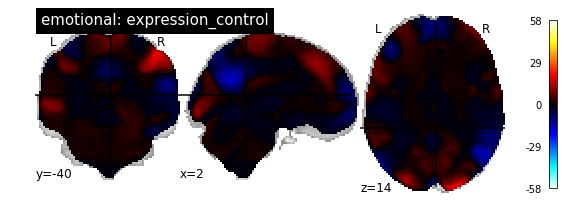

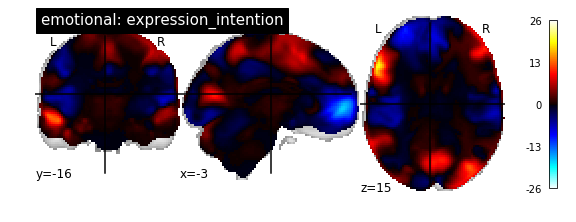

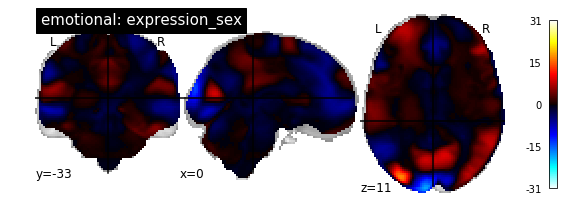

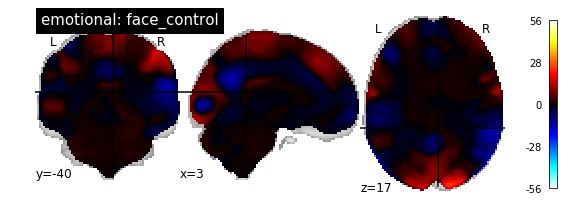

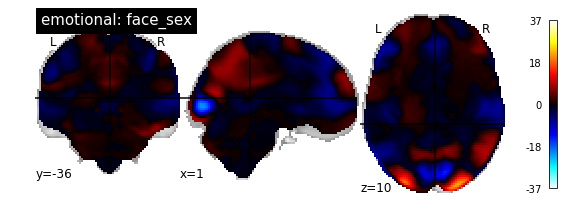

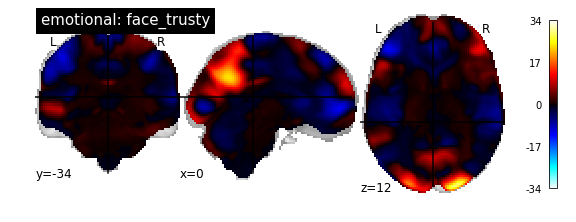

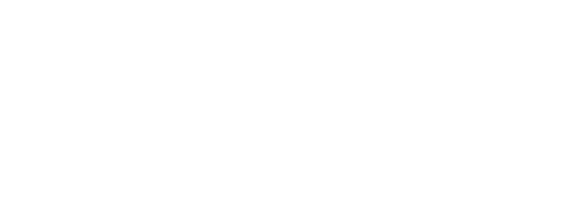

In [395]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [396]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

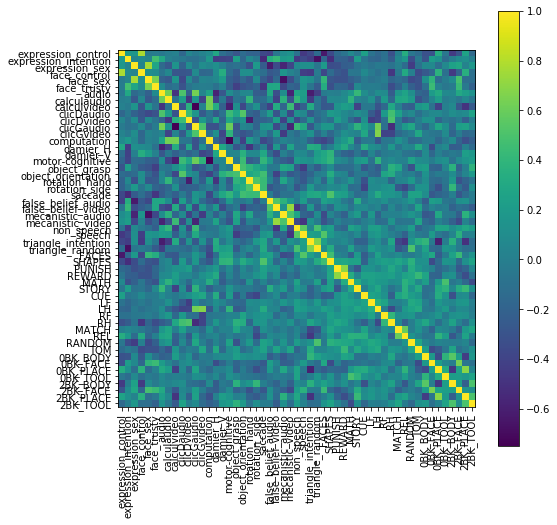

In [397]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [399]:
np.mean(w0 == 0),np.mean(w1 == 0)

(0.0, 0.0)

In [400]:
(np.abs(coef[indices,:16]).sum())

338.73679

In [401]:
(np.abs(coef[indices,16:80])).sum()

2505.4434

In [402]:
np.abs(coef[indices,80:80 + 256]).sum()

12833.283

In [403]:
np.mean(coef[indices, :16] == 0)

0.0

In [404]:
np.mean(coef[indices, 16:80] == 0)

0.0

In [405]:
np.mean(coef[indices, 80:256] == 0)

0.0